# Save full status data to json file

In [ ]:
#install packages if needed
# import sys
# !{sys.executable} -m pip install networkx

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import json 
import datetime
import time
import seaborn as sns
import wordcloud

In [ ]:
# Creating the authentication object
auth = tweepy.OAuthHandler(auth_ap.consumer_key, auth_ap.consumer_secret)
# Setting your access token and secret
auth.set_access_token(auth_ap.access_token, auth_ap.access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

In [ ]:
class TweetMiner(object):
    import auth_ap
    # number of tweets per one pull; there is limit on this
    result_limit    =   20    
    data            =   []
    api             =   False
    
    twitter_keys = {
        'consumer_key':        auth_ap.consumer_key,
        'consumer_secret':     auth_ap.consumer_secret,
        'access_token_key':    auth_ap.access_token,
        'access_token_secret': auth_ap.access_token_secret
    }
    
    
    def __init__(self, keys_dict=twitter_keys, api=api, result_limit = 100):
        
        self.twitter_keys = keys_dict
        
        auth = tweepy.OAuthHandler(keys_dict['consumer_key'], keys_dict['consumer_secret'])
        auth.set_access_token(keys_dict['access_token_key'], keys_dict['access_token_secret'])
        
        self.api = tweepy.API(auth)
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit

    def mine_tweets_user(self, user="", last_tweet_id  =  False, max_pages=17):
        # keep track of last tweet id
        # multiply by the # of result_limit = total tweets
        data_page = []
        page =  1
        
        while page <= max_pages:
            if last_tweet_id:
                statuses   =   self.api.user_timeline(screen_name = user,
                                                     count = self.result_limit,
                                                     # get tweets older than last retrieved ones  
                                                     max_id = last_tweet_id - 1,
                                                     tweet_mode = 'extended',
                                                    )        
            else:
                statuses   =   self.api.user_timeline(screen_name=user,
                                                        count = self.result_limit,
                                                        tweet_mode = 'extended',
                                                        )
            for st in statuses:
                data_page.append(st._json)
                last_tweet_id = st.id

            page += 1
        # returns list of dict
        return data_page, last_tweet_id
    
    def mine_tweets_keyword(self, query = "", language = 'en', last_tweet_id  =  False,
                         max_pages=17):

        data_page = []
        page = 1
        
        while page <= max_pages:
            if last_tweet_id:
                statuses   =   self.api.search(q = query, lang = language,
                                                     count = self.result_limit,
                                                     # get tweets older than last retrieved ones  
                                                     max_id = last_tweet_id - 1,
                                                     tweet_mode = 'extended',
                                                    )        
            else:
                statuses   =   self.api.search(q = query, lang = language,
                                                        count = self.result_limit,
                                                        tweet_mode = 'extended',
                                                 )
    
            for st in statuses:
                data_page.append(st._json)
                last_tweet_id = st.id
            page += 1
        # returns list of dict
        return data_page, last_tweet_id

## Mine tweets by query

In [ ]:
miner = TweetMiner(result_limit = 100)
counter = 1
ls_master = []
q_word = 'AR/VR -game -#nausicaa'
last_id = False
while counter < 15:
    print (counter)
    try:
        
        ls_tweets, last_tweet_id = miner.mine_tweets_keyword(query=q_word, language = 'en', 
                                       last_tweet_id = last_id, max_pages = 34)
        last_id = last_tweet_id
        ls_master.extend(ls_tweets)
    except:
        print ("Limit is reached")
        time.sleep(16*60) #15 minute sleep time
        
    if len(ls_tweets) < 1:
        break
        
    counter+=1

In [ ]:
ls_master[-1]

In [ ]:
fname = 'vr_ar_-game_-nausicaa{}.json'.format(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
with open(fname, 'w', encoding='utf8') as file:
    json.dump(ls_master, file)

In [ ]:
path = r"U:\Data_Analysis\pak6\DS project\vr_ar_-game_-nausicaa2020-09-18-23-26-27.json"
df_3 = pd.read_json(path)
df_3.head()

In [ ]:
df_master = pd.concat([df_1, df_2, df_3])

In [ ]:
df_master.to_pickle("ar-vr_tweets_old.pkl")

## Text processing

In [ ]:
path = r"U:\Data_Analysis\pak6\DS project\ar-vr_tweets.pkl"
df_master = pd.read_pickle(path)
df_master.head()

In [ ]:
from nltk.tokenize import word_tokenize
import re
import operator 
from collections import Counter
from nltk.corpus import stopwords
import string

In [ ]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f][.]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [ ]:
def get_status_text(df_row):
    #retweet
    if isinstance(df_row.retweeted_status, dict):
        text = df_row.retweeted_status['full_text']
    #quote
    elif df_row.quoted_status_id > 0:
        text = df_row.quoted_status["full_text"]
    # regular tweet
    else:
        text = df_row['full_text']
    return text

### Term frequency

In [ ]:
df_tweets = df_master.reset_index(drop=True)

In [ ]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ["amp", "reality", "#machinelearning", "#technology",
                "#virtualreality", "#augmentedreality", "reality", "#iiot", "#artificialintelligence",
                 'virtual', 'augmented' ]


In [ ]:
sns.distplot(df_tweets.entities.apply(lambda x: len(x['hashtags'])).values)

In [ ]:
count_terms = Counter()
count_hash = Counter()

for idx in df_tweets.index[:]:
    text = get_status_text(df_tweets.iloc[idx])
    if len(df_tweets.iloc[idx].entities['hashtags']) > 5:
        continue
    terms_hash = [term for term in preprocess(text) 
              if term not in stop and len(term) > 3 and term.startswith('#')]
    terms_only = [term for term in preprocess(text) 
              if term not in stop and len(term) > 3 and
              not term.startswith(('#', '@'))] 

    # Update the counter
    count_hash.update(terms_hash)
    count_terms.update(terms_only)

print(count_hash.most_common(10))
print(count_terms.most_common(10))

### Wordclouds

In [ ]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

_input = count_terms
wc = WordCloud( mask = mask, contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=50, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

In [ ]:
from PIL import Image
from wordcloud import WordCloud
path_image = r"U:\Data_Analysis\pak6\DS project\Huawei-VR-Glass.jpg"
mask = np.array(Image.open(path_image))

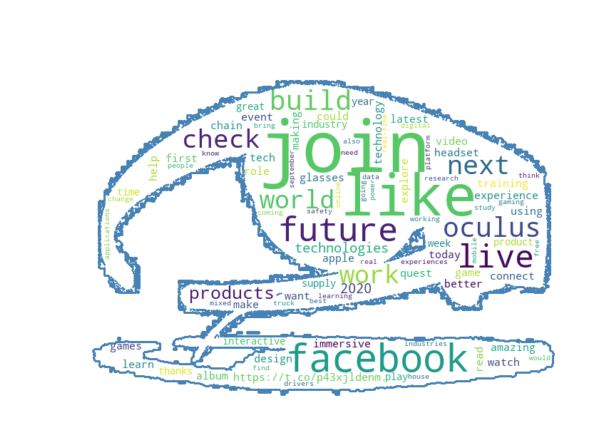

In [521]:
_input = count_terms
wc = WordCloud( mask = mask, contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=100, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
# plt.savefig("wordcloud.png")

### Word co-occurences

In [ ]:
from nltk import bigrams 
count_terms_bigrams = Counter()

for idx in df_tweets.index:
    
    text = get_status_text(df_tweets.iloc[idx])
        
    terms_only = [term for term in preprocess(text) 
              if term not in stop and len(term) > 4 and
              not term.startswith(('#', '@'))] 

    terms_bigram = bigrams(terms_only)
    # Update the counter
    count_terms_bigrams.update(terms_bigram)
    # Print the first 5 most frequent words
print (count_terms_bigrams.most_common(10))

In [ ]:
from collections import defaultdict
# remember to include the other import from the previous post
 
com = defaultdict(lambda : defaultdict(int))
for idx in df_tweets.index:
    
    text = get_status_text(df_tweets.iloc[idx])
        
    terms_only = [term for term in preprocess(text) 
              if term not in stop and len(term) > 2 and
              not term.startswith(('#', '@'))] 

    # Build co-occurrence matrix
    for i in range(len(terms_only)-1):            
        for j in range(i+1, len(terms_only)):
            w1, w2 = sorted([terms_only[i], terms_only[j]])                
            if w1 != w2:
                com[w1][w2] += 1

In [ ]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:5])

#### Term frequency over time

In [ ]:
from matplotlib.dates import DateFormatter

In [ ]:
htag_dict = {}
target_ls = ['#vr', '#iot', "#blockchain", "#oculus"]
for trg in target_ls:
    htag_dict[trg] = []

# f is the file pointer to the JSON data set
for idx in df_tweets.index:
    
    text = get_status_text(df_tweets.iloc[idx])
    # Create a list with all the terms
    terms_hash = [term for term in preprocess(text) 
              if term not in stop and len(term) > 2 and term.startswith('#')]
    
    # track when the hashtag is mentioned
    for trg in target_ls: 
        if trg in terms_hash:
            htag_dict[trg].append(df_tweets.iloc[idx]['created_at'])
 

In [ ]:
ls = []
for key in htag_dict.keys():
    tmp = htag_dict[key]
    ones = [1]*len(tmp)
    idx = pd.DatetimeIndex(tmp)
    tmp = pd.Series(ones, index=idx)
    tmp = tmp.resample('3H').sum().fillna(0).reset_index()
    tmp.columns = ['date', 'freq']
    tmp.loc[:, 'target'] = key
    ls.append(tmp)
df_target_tc = pd.concat(ls)

In [ ]:
from matplotlib.dates import DateFormatter

In [538]:
df_target_tc.head()

,date,freq,target
0,2020-09-04 21:00:00,155,#vr
1,2020-09-05 00:00:00,153,#vr
2,2020-09-05 03:00:00,119,#vr
3,2020-09-05 06:00:00,178,#vr
4,2020-09-05 09:00:00,209,#vr


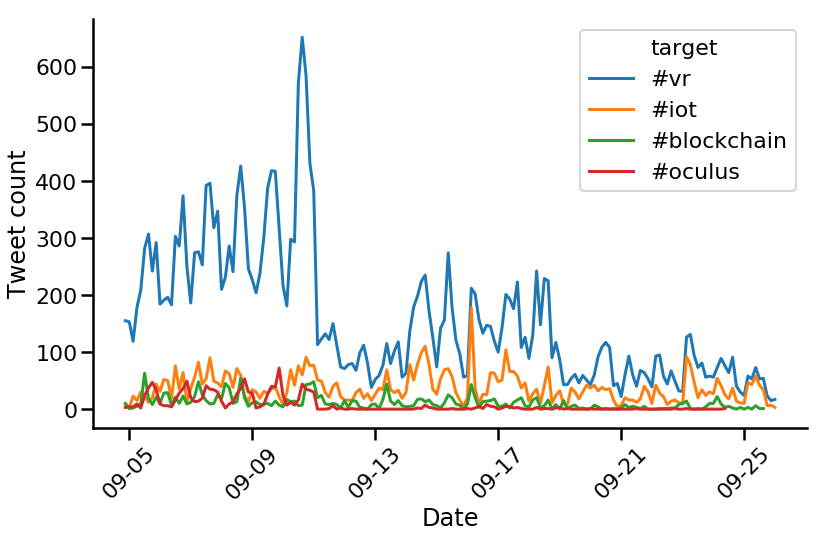

In [519]:
sns.set_context('poster')
f, ax = plt.subplots(figsize =(12, 8))
ax = sns.lineplot(data = df_target_tc, x = 'date', y = 'freq', hue = 'target')
sns.despine()

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Date')
ax.set_ylabel('Tweet count')
# plt.legend(bbox_to_anchor=(.7, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)
plt.tight_layout()
# plt.savefig("top_hashtags_across_time.png")

### Clustering Twitter Users

source https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [ ]:
import itertools
import hdbscan
from nltk.tokenize.casual import TweetTokenizer
# from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE
import logging
# import yaml

In [ ]:
def replace_urls(in_string, replacement=None):
    """Replace URLs in strings. See also: ``bit.ly/PyURLre``

    Args:
        in_string (str): string to filter
        replacement (str or None): replacment text. defaults to '<-URL->'

    Returns:
        str
    """
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)

In [ ]:
def my_tokenizer(in_string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    tokens = tokenizer.tokenize(in_string)
    return tokens

In [ ]:
def make_punc_stopwords(max_length=4):
    """Generates punctuation 'words' up to
    ``max_length`` characters.
    """
    def punct_maker(length):
        return ((''.join(x) for x in itertools.product(string.punctuation,
                                                repeat=length)))
    words = itertools.chain.from_iterable((punct_maker(length)
                                    for length in range(max_length+1)))
    return list(words)

In [ ]:
my_stopwords = list(itertools.chain(stop, make_punc_stopwords(max_length=4)))

In [ ]:
print('current count of stopwords: {}'.format(len(my_stopwords)))
print('example punctuation words:\n {}'.format(my_stopwords[-10:]))

In [ ]:
vec = TfidfVectorizer(preprocessor=replace_urls,
                      tokenizer=my_tokenizer,
                      stop_words=my_stopwords,
                      max_features=unique_user_cnt//100,
                     )

In [ ]:
# create one entry per user
unique_user_map = dict(zip(df_tweets.user.apply(lambda x: 
                            x["id"]).values, df_tweets.user.apply(lambda x: x["description"]).values))

# we need to maintain the same ordering of users and bios
unique_users = []
unique_bios = []
for user,bio in unique_user_map.items():
    unique_users.append(user)
    if bio is None:
        # special case for empty bios
        bio = ''
    unique_bios.append(bio)

In [ ]:
# calculate the data matrix
bio_matrix = vec.fit_transform(unique_bios)

bio_matrix

In [ ]:
print('* original bio text *\n')

for i,bio in enumerate(unique_bios[:10]):
    print(i,': ', bio.replace('\n',' '))

In [ ]:
(pd.DataFrame(bio_matrix[:10].todense(),
              columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,90:110])

#### k-means

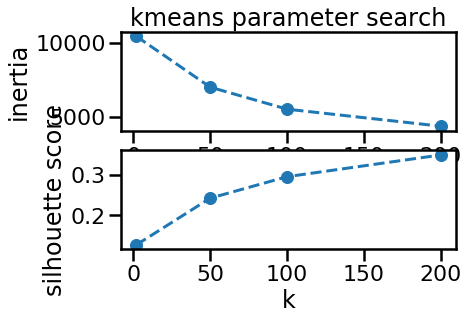

In [522]:
# %%time
# compare a broad range of ks to start
ks = [2, 50, 100, 200]
seed = 3

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
#     logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, random_state=seed)
    model.fit(bio_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(bio_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [ ]:
best_k = 20

km_model = KMeans(n_clusters=best_k, n_jobs=-1, random_state=seed)
km_model.fit(bio_matrix)

In [ ]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [ ]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);
sns.despine()
# plt.tight_layout()

In [ ]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        # -1 is a noise cluster
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [ ]:
strongest_features(km_model, vec, topk=15)

In [ ]:
def cluster_sample(orig_text, model, idx, preview=15):
    """
    Helper function to display original bio for
    those users modeled in cluster `idx`.
    """
    for i,idx in enumerate(np.where(model.labels_ == idx)[0]):
        print(orig_text[idx].replace('\n',' '))
        print()
        if i > preview:
            print('( >>> truncated preview <<< )')
            break

In [ ]:
# feel free to modify this
interest_idx = 5

cluster_sample(unique_bios, km_model, interest_idx)

In [ ]:
def fit_tsne(file=None):
    if file is None:
        file = "data/bio_matrix_2d.npy"
    try:
        bio_matrix_2d = np.load(file)
        logging.warning("loading cached TSNE file")
    except FileNotFoundError:
        logging.warning("Fitting TSNE")
        tsne = TSNE(n_components=2,
                    n_jobs=-1,
                    random_state=seed)
        bio_matrix_2d = tsne.fit_transform(bio_matrix.todense())

        np.save(file, bio_matrix_2d)
    return bio_matrix_2d

In [ ]:
tsne_file = "bio_matrix_2d.npy"

In [ ]:
%%time
bio_matrix_2d = fit_tsne(tsne_file)

In [ ]:
def get_plottable_df(users, bios, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart.

    Note: assumes that all argument data series
    are in the same order e.g. the first user, bio, coords, and label
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    # combine data into a single df
    df = pd.DataFrame({'uid': users,
                       'text': bios,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1],
                      })
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

In [ ]:
km_plottable_bios = get_plottable_df(unique_users, unique_bios, bio_matrix_2d, km_model.labels_)

km_plottable_bios.head()

In [ ]:
def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""")
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

In [ ]:
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
import joblib

In [526]:

show(plot_tsne(km_plottable_bios.sample(5000),
               't-sne projection of kmeans-clustered users ["(cluster #) bio"]'))

In [533]:
from bokeh.io import export_png

export_png(plot_tsne(km_plottable_bios.sample(5000)), filename="tsne_kmeans_users.png")

'U:\\Data_Analysis\\pak6\\DS project\\tsne_kmeans_users.png'

In [534]:
from bokeh.plotting import figure, output_file, save
p = plot_tsne(km_plottable_bios.sample(5000))
output_file("test.html")
save(p)

'U:\\Data_Analysis\\pak6\\DS project\\test.html'

In [531]:
# import sys
!{sys.executable} -m pip install selenium
# !conda install --yes --prefix {sys.prefix} bokeh

#### HDBSCAN

In [ ]:
def maybe_fit_hdbscan(filename=None):
    if filename is None:
        filename = 'data/hdbscan.pkl'
    try:
        hdbs = joblib.load(filename)
        logging.warning("loading cached HDBSCAN model")
    except FileNotFoundError:
        logging.warning("fitting HDBSCAN model")
        hdbs = hdbscan.HDBSCAN(min_cluster_size=100,
                               prediction_data=True,
                               core_dist_n_jobs=-1,
                               memory='data')
        hdbs.fit(bio_matrix.todense())
        joblib.dump(hdbs, filename)

    return hdbs

In [ ]:
hdbscan_file = 'data/hdbscan.pkl'

In [ ]:
%%time
hdbs = maybe_fit_hdbscan(hdbscan_file)

In [ ]:
# get the population sizes
label_counts = Counter(hdbs.labels_)
xs, ys = [], []
for k,v in label_counts.items():
    xs.append(k)
    ys.append(v)

# draw the chart
plt.bar(xs, ys)

plt.xticks(range(-1, len(label_counts)))
plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes ({} clusters found by hdbscan)'.format(len(label_counts) - 1));
sns.despine()

In [ ]:
strongest_features(hdbs, vec, topk=15)

In [ ]:
interest_idx = 0

cluster_sample(unique_bios, hdbs, interest_idx)

In [ ]:
# pass in the cluster assignments from the hdbscan model
hdb_plottable_bios = get_plottable_df(unique_users, unique_bios, bio_matrix_2d, hdbs.labels_)

hdb_plottable_bios.head()

In [535]:
show(plot_tsne(hdb_plottable_bios.sample(5000),
               't-sne projection of hdbscan-clustered users ["(cluster #) bio"]'))

In [537]:
from bokeh.plotting import figure, output_file, save
p = plot_tsne(hdb_plottable_bios.sample(5000))
output_file("tsne_hdbscan_users_bio.html")
save(p)

'U:\\Data_Analysis\\pak6\\DS project\\tsne_hdbscan_users_bio.html'

In [ ]:
df_tweets.columns

In [ ]:
df_tweets[(df_tweets.user.apply(lambda x: x["id"]) == 34181507) ].iloc[0].user["followers_count"]

In [ ]:
for idx, val in user_replies.most_common(10):
    x = df_tweets[(df_tweets.user.apply(lambda x: x["id"]) == idx) ].iloc[0].user["followers_count"]
    print (x)

In [ ]:
_inp = df_tweets[df_tweets.is_quote_status == True].user.apply(lambda x:x ["screen_name"])
user_replies = Counter(_inp)
user_replies.most_common(10)

In [ ]:
replies.most_common(10)[0][0]

In [ ]:
replies = Counter(df_tweets[df_tweets.quoted_status_id > 0].quoted_status_id.values)
replies.most_common(10)

In [ ]:
for col in df_tweets.columns:
    if col.endswith('str'):
        print (col[:-4])
        df_tweets[col] = df_tweets[col[:-4]].astype(str)

In [ ]:
1.3052068773079286

In [ ]:
pd.reset_option('display.float_format')

In [ ]:
for i in range(10):
    print (get_status_text(df_tweets[df_tweets.is_quote_status == True].iloc[i]))
    print ((df_tweets[df_tweets.is_quote_status == True].iloc[i].quoted_status))
    print ("------------")
    break

# NetworkX interactions

source https://github.com/ugis22/analysing_twitterA  
A better approach is to create a graph in NetworkX and use Gephi to run analysis and visualize the graph  
Use this guide to analyze the graph https://www.slideshare.net/gephi/gephi-quick-start?ref=https://gephi.org/users/quick-start/  
another good read https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python  

In [ ]:
# Create a second dataframe to put important information
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])

def add_user_info(tweets_final):
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final

# add retweets
def add_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will add 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final

# add the user mentions 
def add_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will add 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final


# add the information about replies
def add_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
    return tweets_final

def fill_df(tweets_final):
    add_user_info(tweets_final)
    add_usermentions(tweets_final)
    add_retweets(tweets_final)
    add_in_reply(tweets_final)
    return tweets_final


In [ ]:
import networkx as nx
from scipy.stats import mode
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [ ]:
# Columns that are going to be the same
tweets_df = df_tweets
equal_columns = ["created_at", "id", "full_text"]
tweets_final[equal_columns] = tweets_df[equal_columns]# Get the basic information about user 
tweets_final = fill_df(tweets_final)
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)

In [ ]:
tweets_final.head()

In [ ]:
active_users = tweets_final.groupby('user_id').id.count().reset_index()
active_users = active_users[active_users.id > 0].user_id.values

In [ ]:
G = nx.Graph()

In [ ]:
tweets_final[tweets_final.user_id.isin(active_users)]

In [ ]:
for index, tweet in tweets_final[tweets_final.user_id.isin(active_users)].iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        G.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        G.nodes[user_id]["name"] = user_name
        G.nodes[int_id]["name"] = int_name



In [ ]:
print("There are {} nodes and {} edges present in the Graph".format(G.number_of_nodes(), G.number_of_edges()))

In [ ]:
density = nx.density(G)
print("Network density:", density)


In [ ]:
degrees = [val for (node, val) in G.degree()]

print("The maximum degree of the Graph is {}".format(np.max(degrees)))   
print("The minimum degree of the Graph is {}".format(np.min(degrees)))

print("The average degree of the nodes in the Graph is {}".format(np.mean(degrees)))  
print("The most frequent degree of the nodes found in the Graph is {}".format(mode(degrees)[0][0]))

In [ ]:
if nx.is_connected(G):
    print("The graph is connected")
else:
    print("The graph is not connected")

In [ ]:
print("There are {} connected components in the Graph".format(nx.number_connected_components(G)))

#### Find the largest subgraph

In [ ]:
largest_subgraph = sorted(nx.connected_components(G), key=len, reverse=True)
largest_subgraph = G.subgraph(largest_subgraph[0])
print("There are {} nodes and {} edges present in the largest component of the \
Graph".format(largest_subgraph.number_of_nodes(), largest_subgraph.number_of_edges()))



In [ ]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

In [ ]:
print("The average clustering coefficient is {} in the largest subgraph".format(nx.average_clustering(largest_subgraph)))
print("The transitivity of the largest subgraph is {}".format(nx.transitivity(largest_subgraph)))

In [ ]:
print("The diameter of our Graph is {}".format(nx.diameter(largest_subgraph)))
print("The average distance between any two nodes is {}".format(nx.average_shortest_path_length(largest_subgraph)))

#### FInd important nodes

In [ ]:
from operator import itemgetter

In [ ]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [ ]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [ ]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [ ]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [ ]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [ ]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [ ]:
print("the node with id {} has a degree centrality of {} which is the maximum of the Graph".format(max_de[0], max_de[1]))
print("the node with id {} has a closeness centrality of {} which is the maximum of the Graph".format(max_clo[0], max_clo[1]))
print("the node with id {} has a betweenness centrality of {} which is the maximum of the Graph".format(max_bet[0], max_bet[1]))

In [ ]:
betweenness_dict = nx.betweenness_centrality(G, normalized=True, endpoints=False) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')


In [ ]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = ['968008274003005440', '2270694806']

In [ ]:
pos = nx.spring_layout(largest_subgraph)

In [ ]:
len(largest_subgraph.nodes)

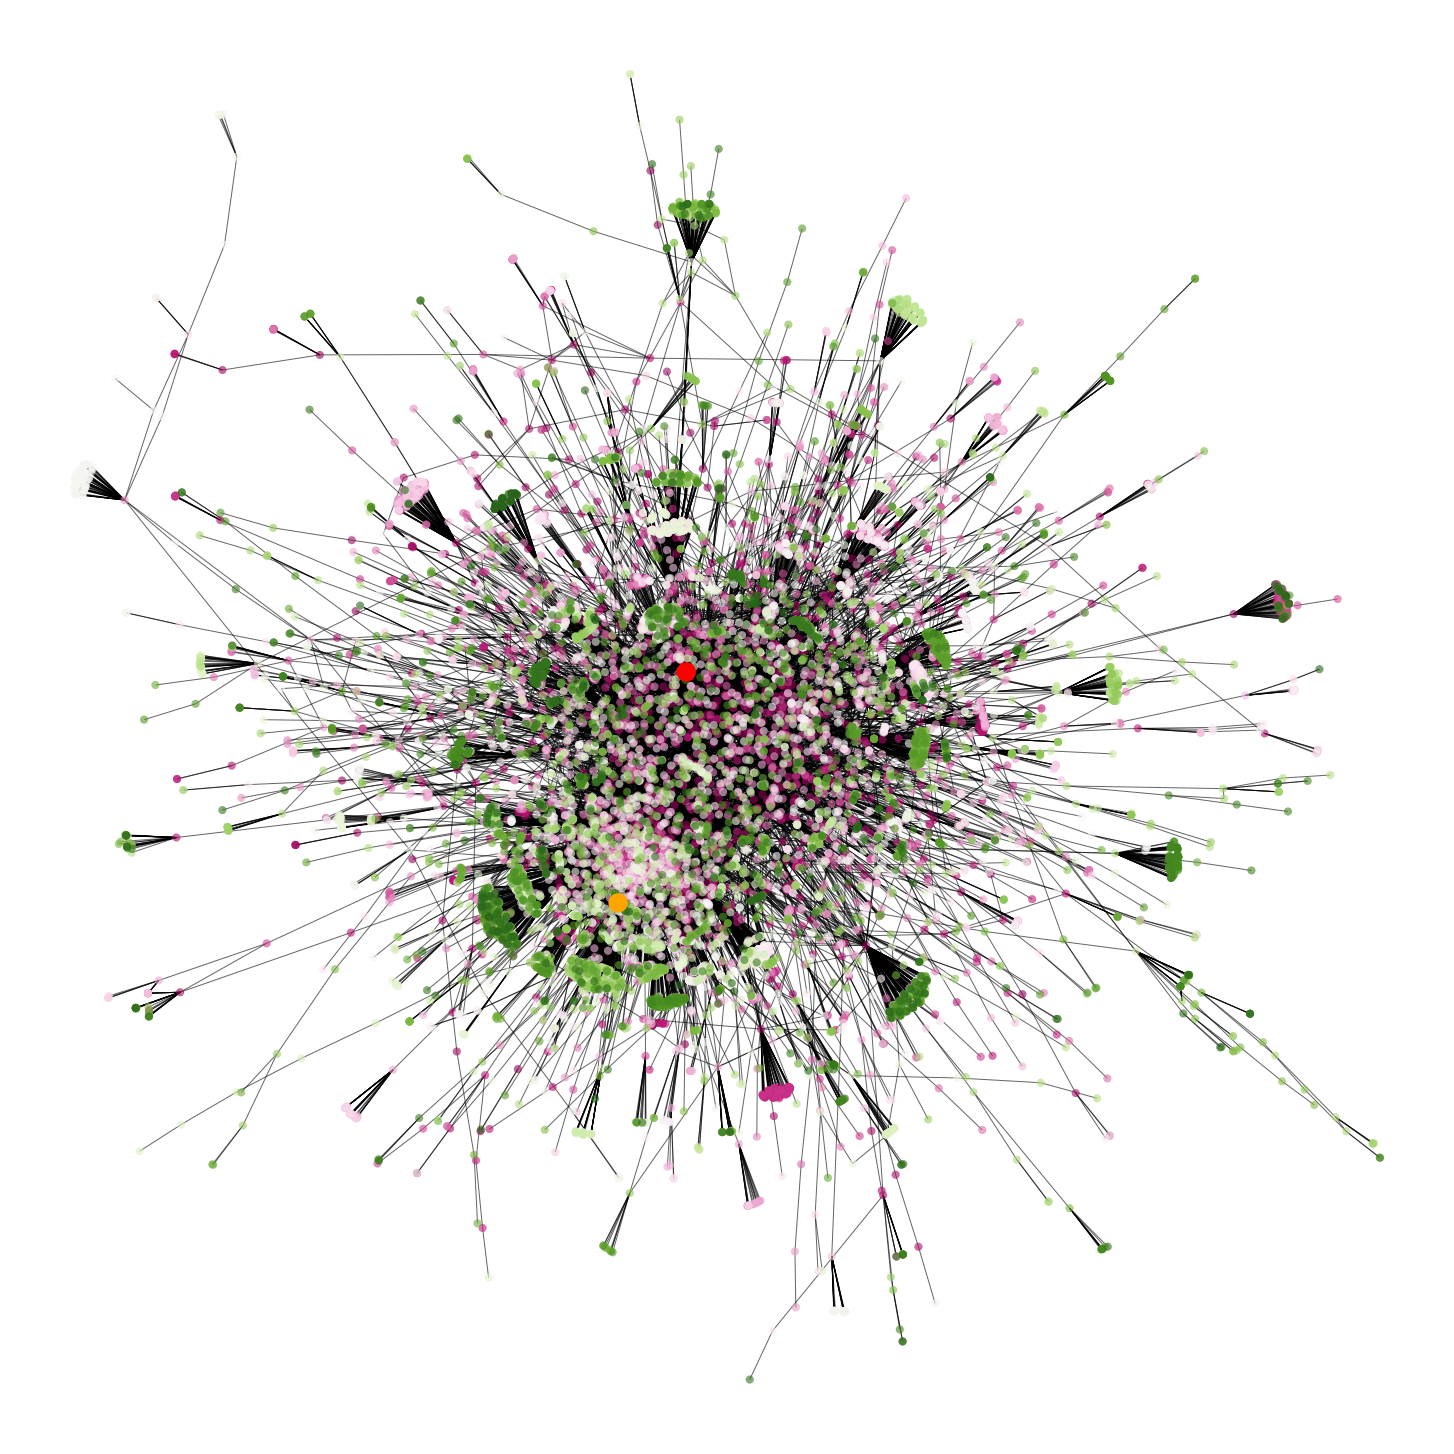

In [509]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(11658), 
        cmap=plt.cm.PiYG, 
        edge_color="black", 
        linewidths=0.3, 
        node_size=60, 
        alpha=0.6, 
        with_labels=False)

nx.draw_networkx_nodes(largest_subgraph, pos=pos, 
                       nodelist=central_nodes, node_size=300, 
                       node_color=colors_central_nodes)




#### Export the graph to Gephy

In [ ]:
nx.write_gexf(G, 'tweet_vr_graph_v2.gexf')

#### Detect Communities

In [ ]:
from networkx.algorithms import community

In [ ]:
communities = community.greedy_modularity_communities(graph)


In [ ]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(graph, modularity_dict, 'modularity')


In [ ]:
# First get a list of just the nodes in that class
class0 = [n for n in graph.nodes() if graph.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:graph.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])


In [ ]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 10: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', len(c)) # Print out the classes and their members